# /r/india Subreddit Data Analysis Part 1

This is a simple data exploration of /r/india subreddit to identify access patterns, just for fun. As this is a jupyter notebook, you will see code interspersed with images and comments. This is intentional. It gives you an idea on how this data is processed and extracted so you can be sure of the data. It is also instructional, if you are interested in data exploration like this. If you are not a coder, simply skip those code sections. :)

If you are not interested in knowing how this data analysis is done, feel free to skip this section and head straight to pretty graphs.


## Data Extraction Process

The data set contains data from 09/2016 to 09/2017 so an years worth of data downloaded from reddit public dataset on Google BigQuery at https://bigquery.cloud.google.com. I ran the following query to download submissions:

```sql
    SELECT id, created_utc, author, num_comments, score, ups, downs, title, selftext, link_flair_text FROM `fh-bigquery.reddit_posts.201*` where subreddit="india" and _TABLE_SUFFIX BETWEEN '6_09' and '7_09' and num_comments > 1 and selftext != '[deleted]' and selftext !='[removed]'and score > 2
```

And the following query to download comments:

```sql
    SELECT id, created_utc, author, body, score, ups, downs, parent_id FROM `fh-bigquery.reddit_comments.201*` where subreddit="india" and _TABLE_SUFFIX BETWEEN '6_09' and '7_09' and score > 0
```

As you can see I did some filtering on data to reduce the data size so I maybe downstating some numbers in this analysis. I had to export this data to a custom table and then export to a Google Cloud Storage bucket. It is relatively straightforward to download data from Google Cloud Storage once you export data over there. This approach is very fast compared to using praw for querying reddit, as you get a bulk of data without making thousands of queries. Unfortunately, this public dataset hosted on BigQuery didn't have user data like when a user joined, their karma and score. This required me to make bulk queries using praw anyway. I will have that code added at the bottom of this post, if you are interested.

When exporting data from BigQuery, I used "avro" export format as it holds schema information, which makes it easy to parse the data in python. Alternatively, one can use csv or json format. If you choose to use either of those, please keep in mind that submission title and comments may contain a comma or other punctuation marks that might affect parsing.

## Local Database Schema

Once I downloaded the data, I loaded it into a local sqlite database. Overall the data size isn't large enough to necessitate heavyweight databases and any performance reasons aren't an issue because I have a powerful computer to load and process. In sqlite database, I created three tables called submissions, comments and users. No awards for guessing what they hold. Here is the exact SQL queries that I used to create those tables

```sql
    CREATE TABLE users (user_id text PRIMARY KEY, user_since timestamp, link_karma real, comment_karma real)

    CREATE TABLE submissions (submission_id text PRIMARY KEY, title text, content text, link_flair_text text, posted_at timestamp, posted_by text, upvotes int, downvotes int, score int, num_comments int)
		
    CREATE TABLE comments (comment_id text PRIMARY KEY, submission_id text, parent_comment_id text, content text, posted_at timestamp, posted_by text, upvotes int, downvotes int, score int)
```

Unfortunately BigQuery public dataset for comments doesn't contain any submission identifier for comment other than parent_id. So this requires some preprocessing to identify the submission id.

I gathered details of all the users who posted atleast one submission or comment during the timeperiod by making queries to reddit api and stored that details in users table.

In the below sections, you will see a lot of data is extracted by making SQL queries to above tables. Majority of the data can be extracted by simple queries. I will have a separate post that does more post-processing on this data but for now, this should be a good start.

In [106]:
%matplotlib inline

import matplotlib.pyplot as plt
import sqlite3
import tabulate

from datetime import datetime
from IPython.display import HTML, display
%config InlineBackend.figure_format = 'retina'

conn=sqlite3.connect('reddit.db')
cursor=conn.cursor()

def plot_data(xdata, ydata, xlabel, ylabel, title, kind='bar', color='blue', width=15, imwidth=12, imheight=4):
    fig = plt.figure(figsize=(imwidth, imheight), dpi=80)
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.bar(xdata, ydata, width=width, color=color)

## Distribution of User Activity By Month

This subreddit started seeing a lot more activity these days so I wanted to see how dramatic is the increase over last year. It turns out that we had a massive spike around November 2016 that persisted for the most part. I thought the spike may have been because of demonetization but I don't know if it is because of new users or existing users participating more so I tried to look at new users joined during the period of Sept-Dec 2016. I included before and after time to see if a lot more people joined during the time. It turns out that wasn't the case. We didn't have a spike of new users. It's just existing users participating more.

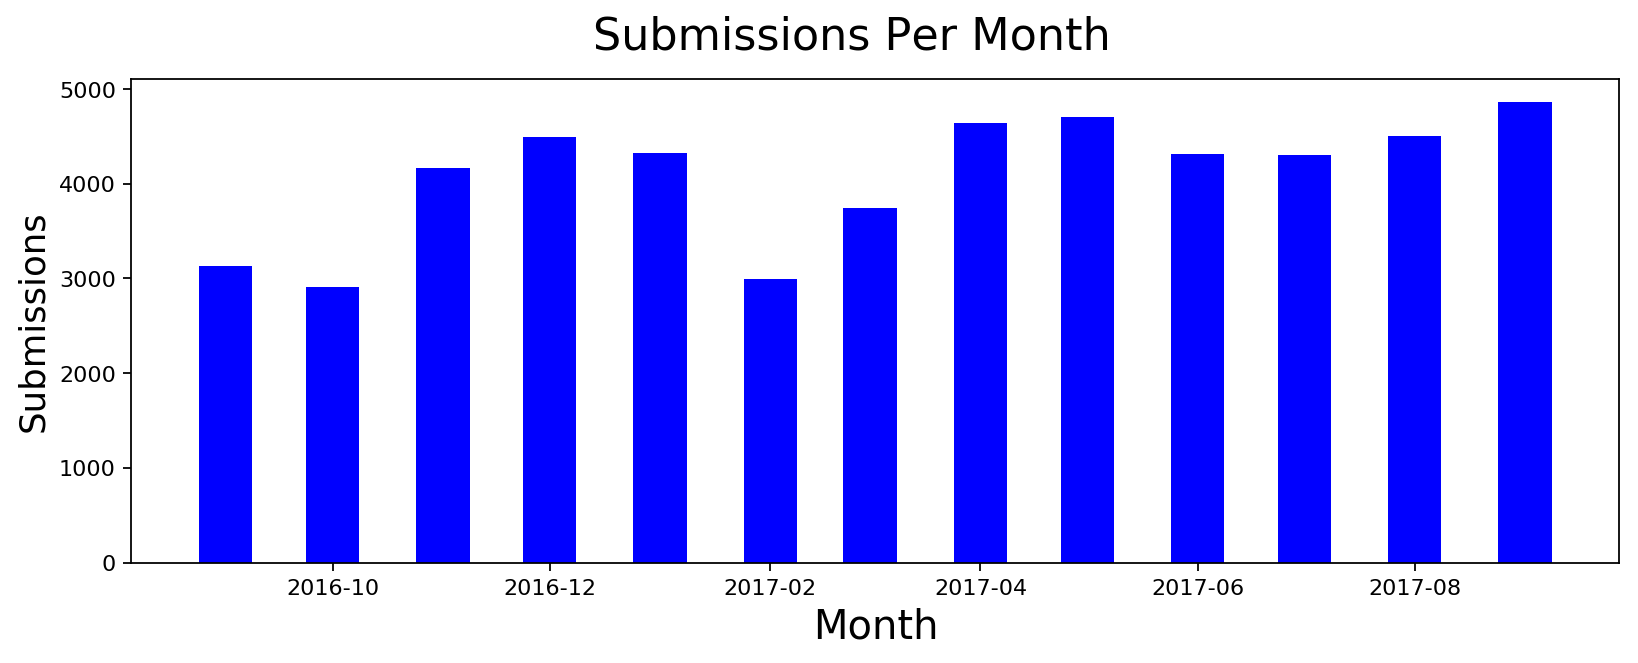

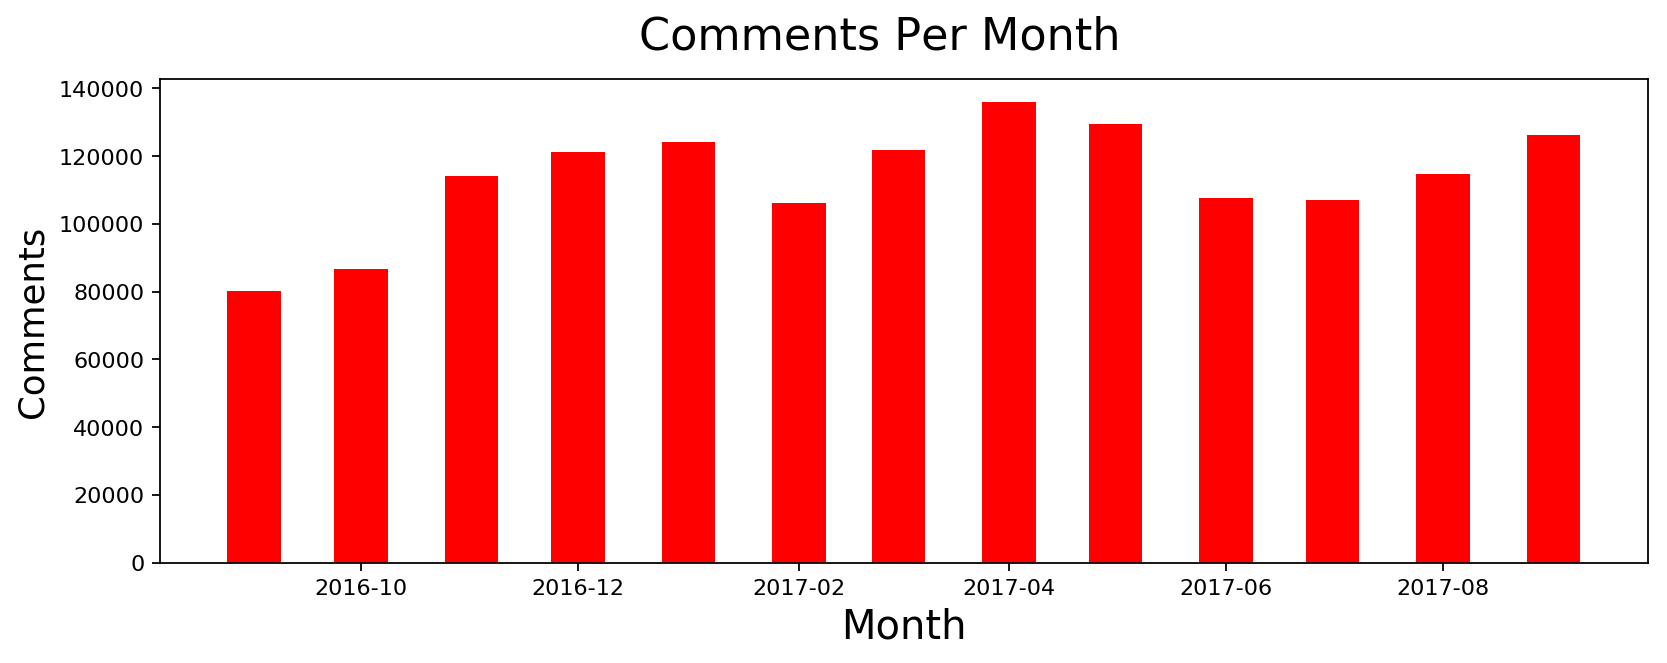

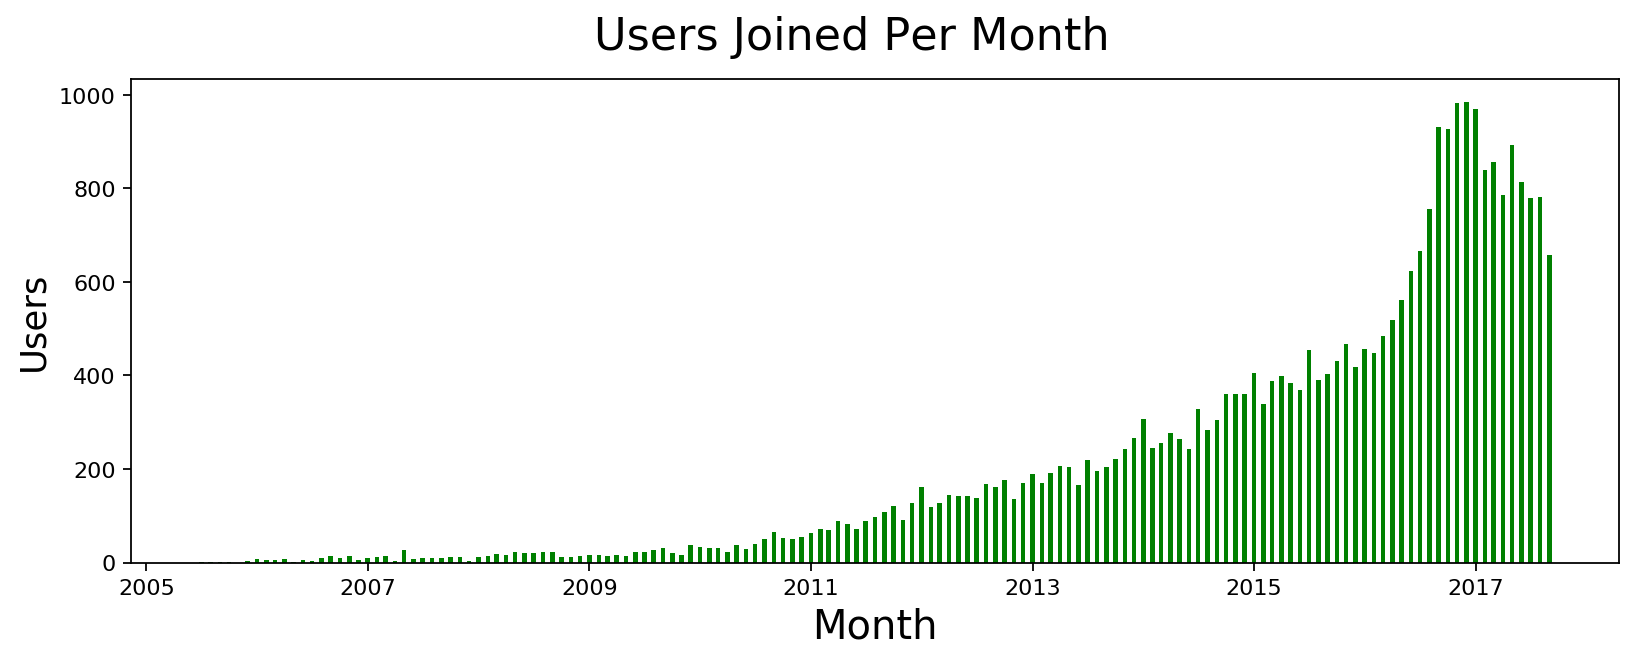

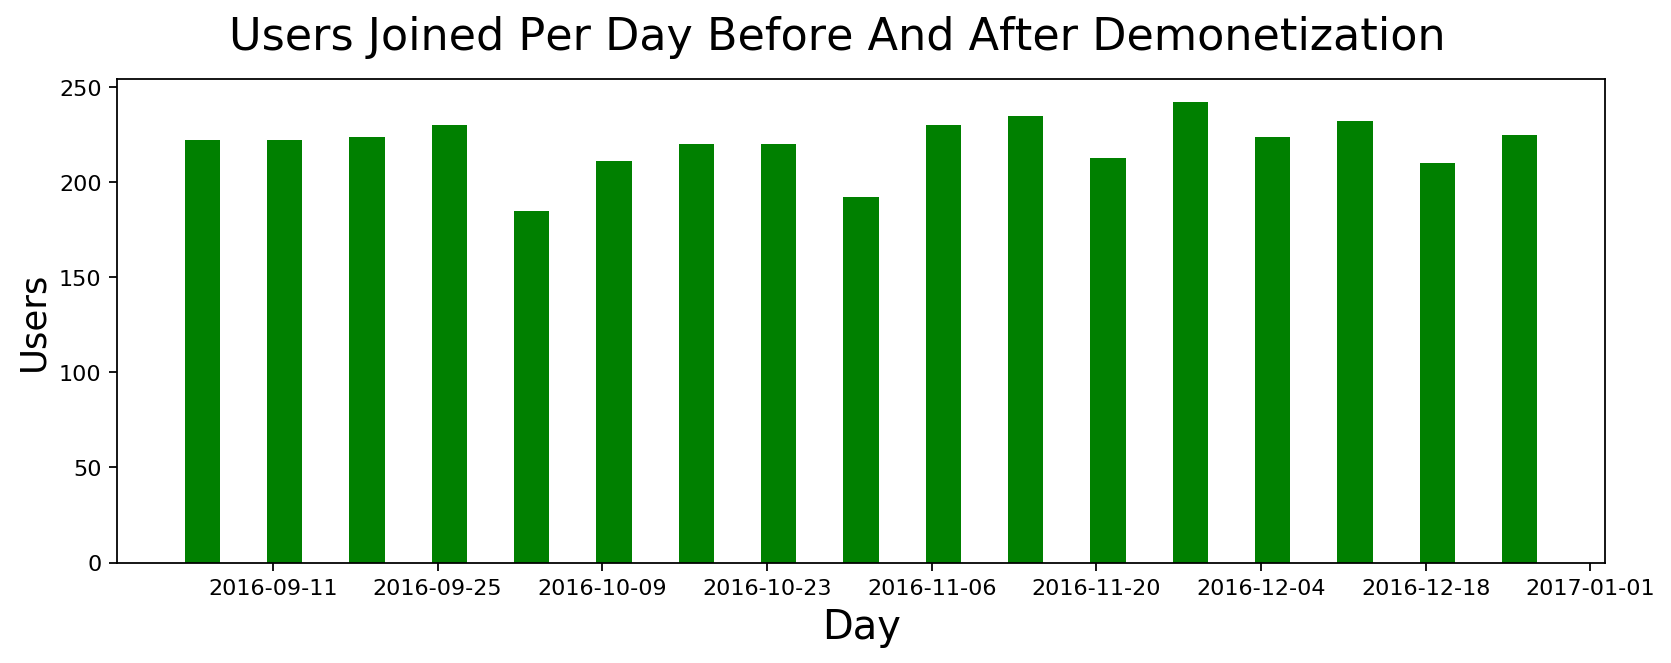

In [108]:
# Monthly stats
submissions_monthly = cursor.execute("select date(posted_at, 'start of month') as month, count(*) from submissions group by month").fetchall()
comments_monthly = cursor.execute("select date(posted_at, 'start of month') as month, count(*) from comments group by month").fetchall()
users_monthly = cursor.execute("select date(user_since, 'start of month') as month, count(*) from users group by month").fetchall()
new_users_sept_dec = cursor.execute("select date(user_since, 'weekday 1') as day, count(*) as count from users where day>'2016-09-01' and day<='2016-12-31' group by day").fetchall()

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in submissions_monthly], [y for x,y in submissions_monthly],
          'Month', 'Submissions', 'Submissions Per Month', color='blue')

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in comments_monthly], [y for x,y in comments_monthly],
          'Month', 'Comments', 'Comments Per Month', color='red')

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in users_monthly], [y for x,y in users_monthly],
          'Month', 'Users', 'Users Joined Per Month', color='green')

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in new_users_sept_dec], [y for x,y in new_users_sept_dec],
          'Day', 'Users', 'Users Joined Per Day Before And After Demonetization', color='green', width=3, imwidth=12)

## Distribution of User Activity across different days of the Week

I wanted to know if we are more active during any day of the week. There is minor variation but nothing notable. It truly seems like a daily pasttime of everyone in the subreddit.

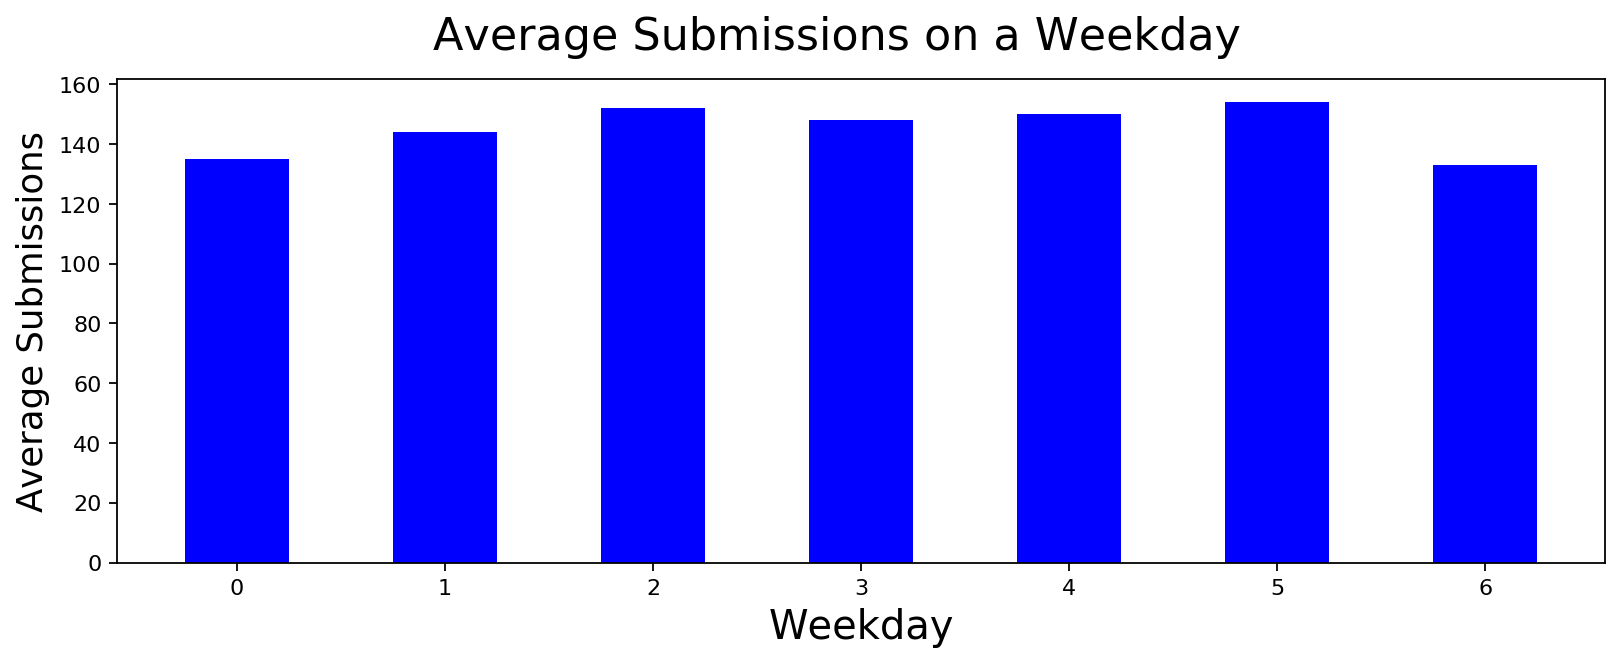

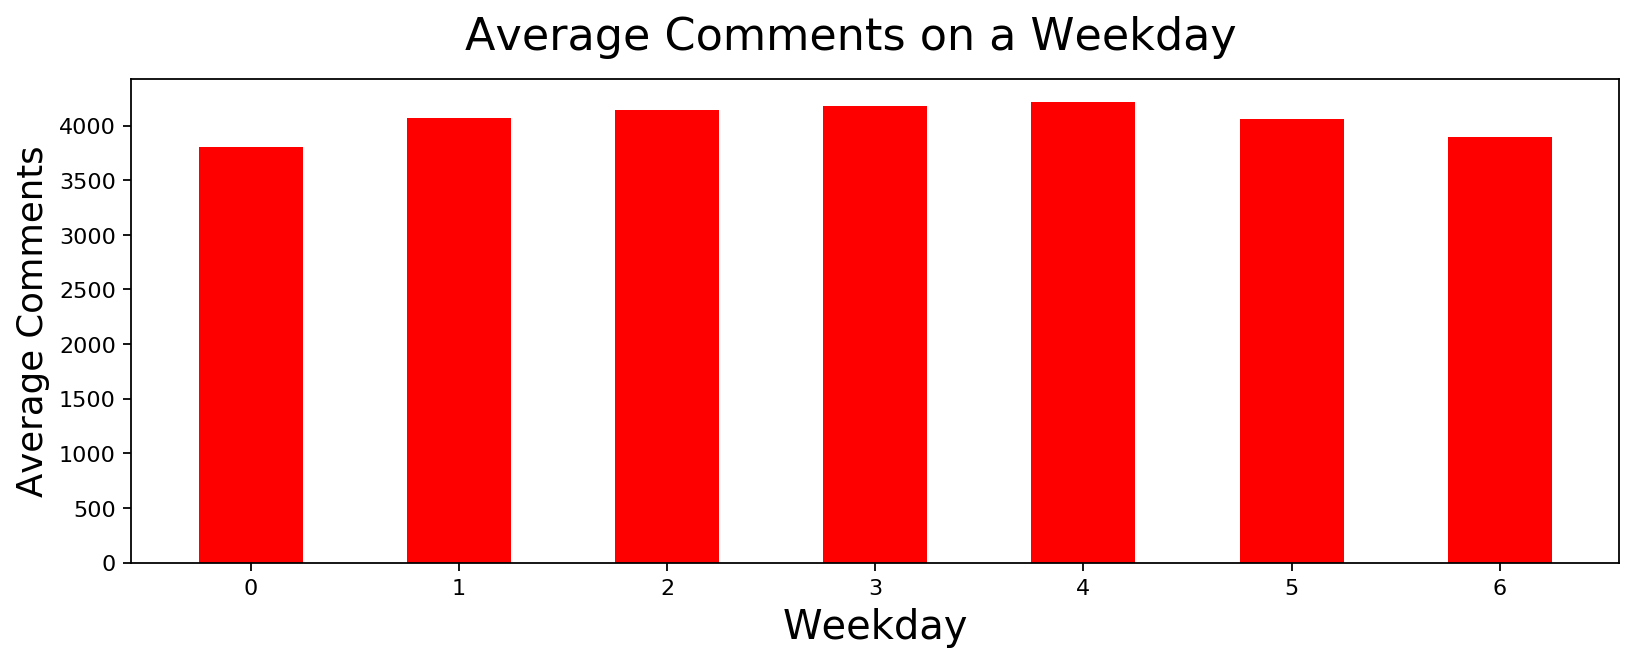

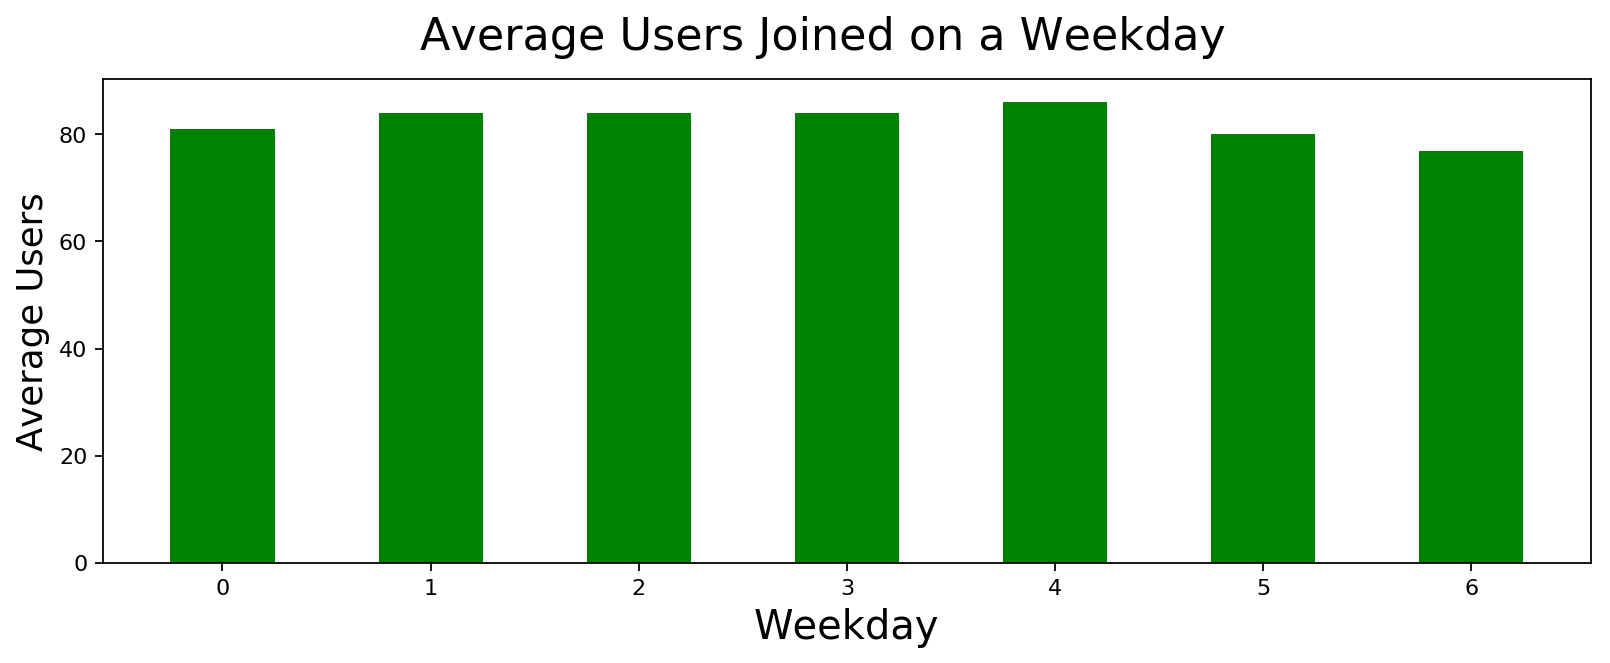

In [109]:
# Weekly stats
submissions_weekday = cursor.execute("select weekday, avg(count) from (select strftime('%w', posted_at) as weekday, strftime('%W', posted_at) as week, count(*) as count from submissions group by week, weekday) group by weekday").fetchall()
comments_weekday = cursor.execute("select weekday, avg(count) from (select strftime('%w', posted_at) as weekday, strftime('%W', posted_at) as week, count(*) as count from comments group by week, weekday) group by weekday").fetchall()
users_weekday = cursor.execute("select weekday, avg(count) from (select strftime('%w', user_since) as weekday, strftime('%W', user_since) as week, count(*) as count from users group by week, weekday) group by weekday").fetchall()

plot_data([int(x) for x,y in submissions_weekday], [int(y) for x,y in submissions_weekday], 'Weekday', 'Average Submissions', 
          'Average Submissions on a Weekday', color='blue', width=0.5)

plot_data([int(x) for x,y in comments_weekday], [int(y) for x,y in comments_weekday], 'Weekday', 'Average Comments',
          'Average Comments on a Weekday', color='red', width=0.5)

plot_data([int(x) for x,y in users_weekday], [int(y) for x,y in users_weekday], 'Weekday', 'Average Users',
          'Average Users Joined on a Weekday', color='green', width=0.5)

## Distribution of User Activity across different times of the Day

It looks like the first thing that people do after going to office is to access reddit. I guess one could use this information to gain traction when posting messages or submissions. Other than that, nothing unexpected here.

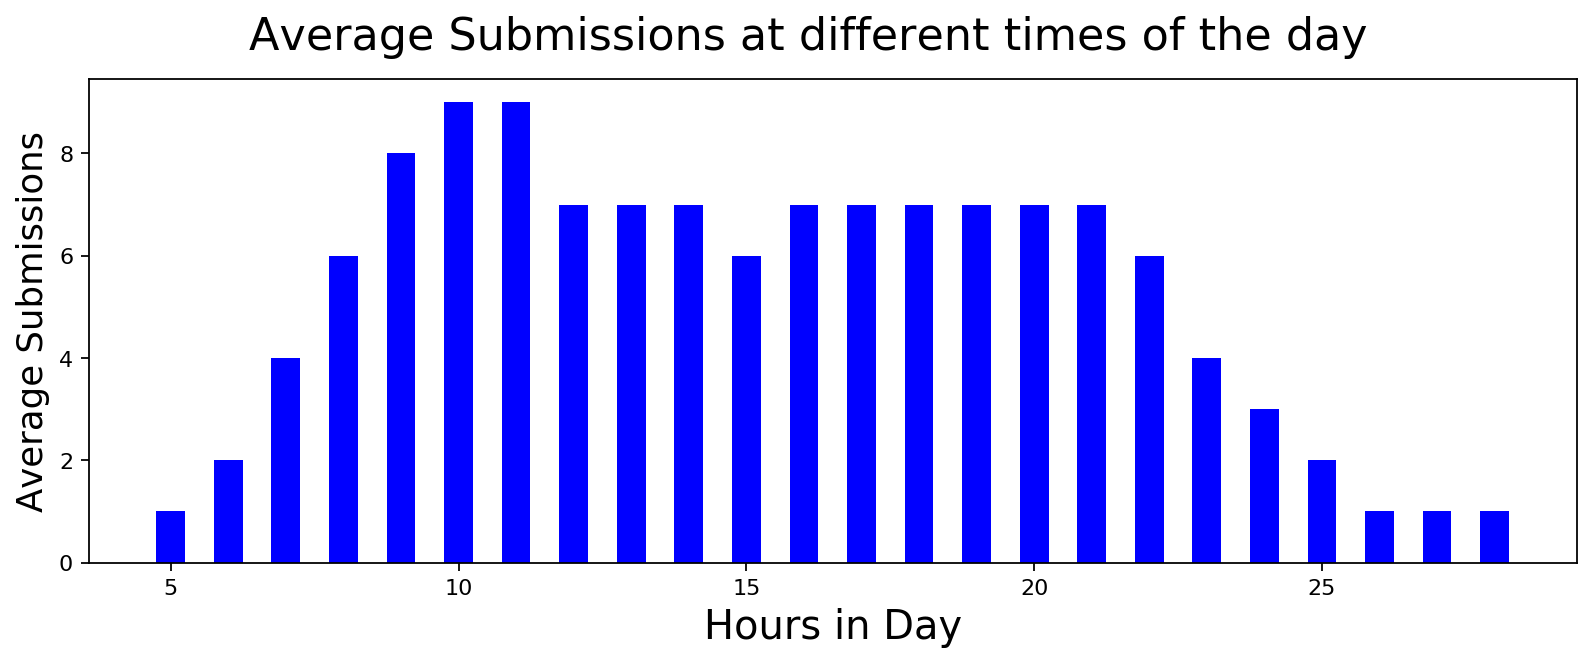

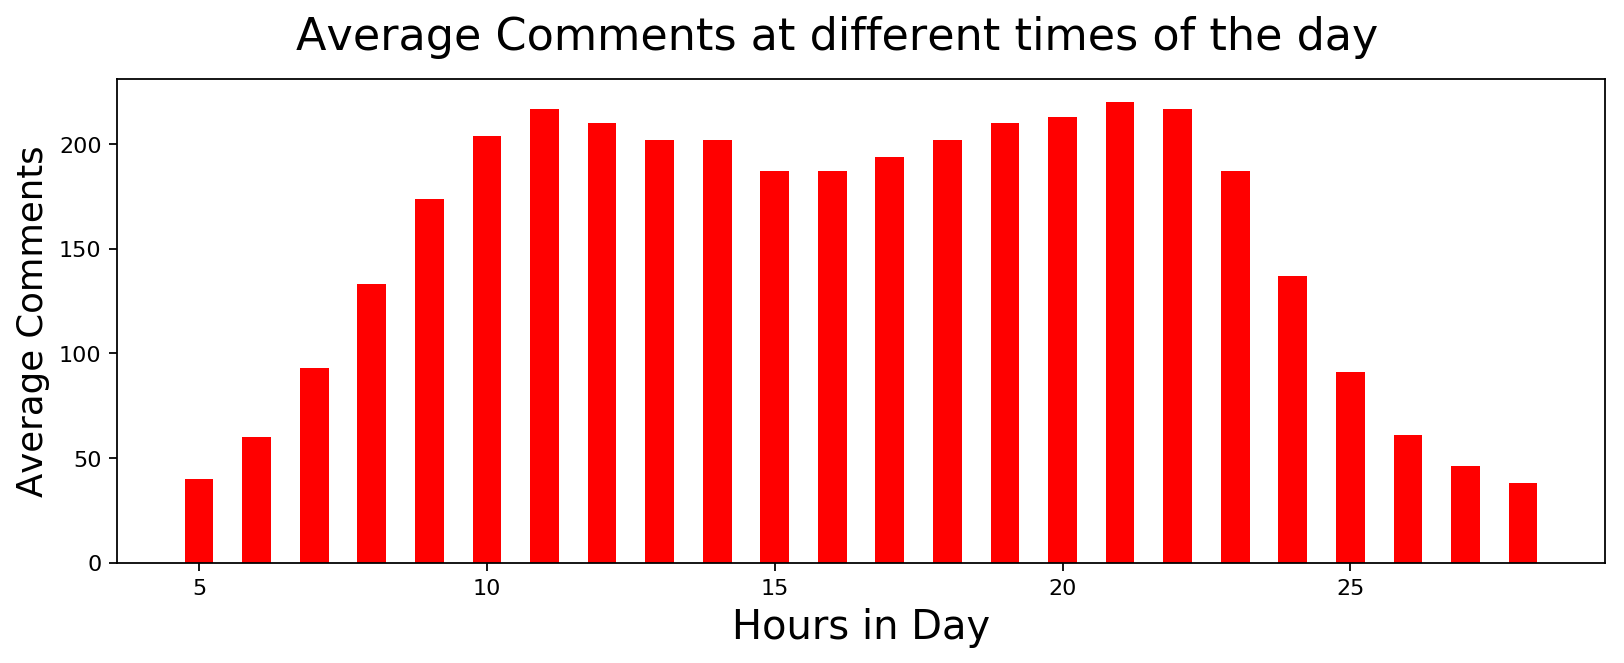

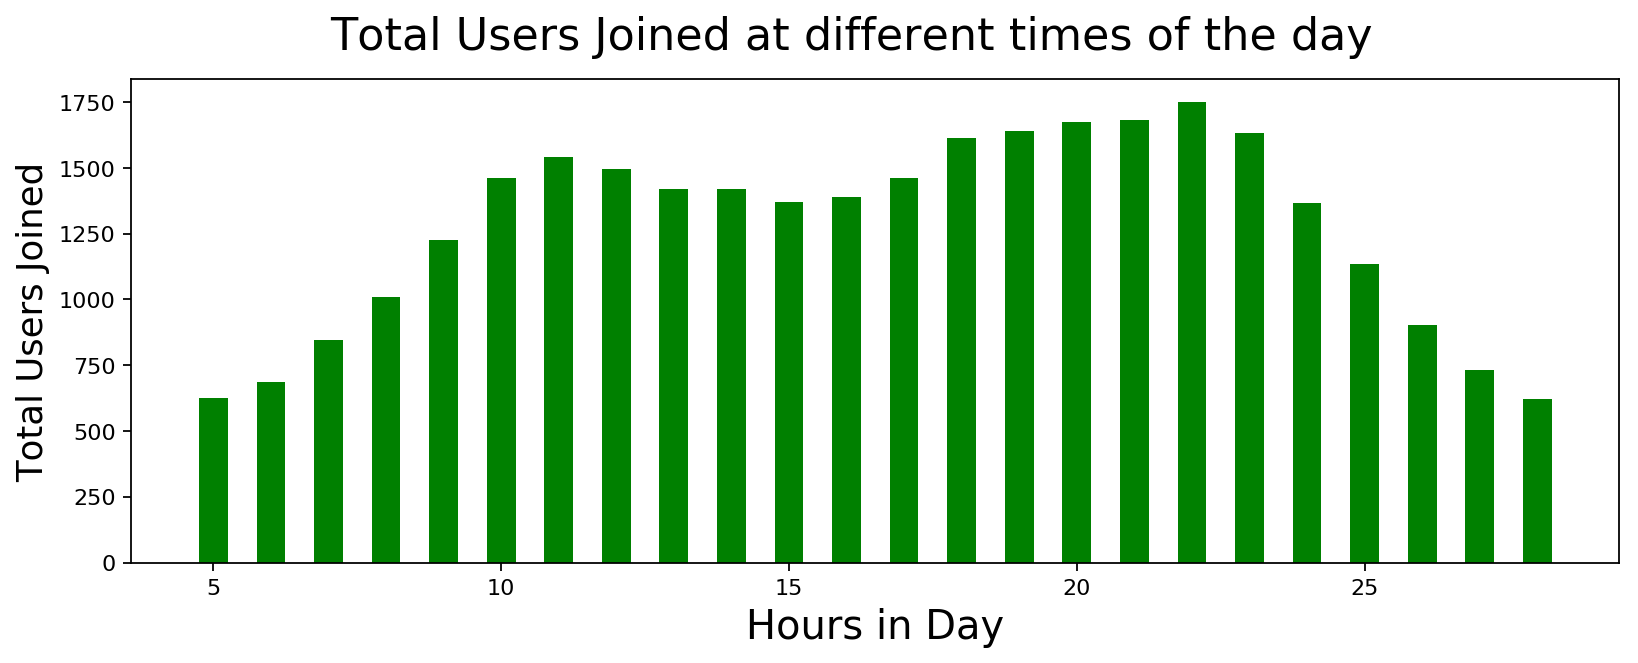

In [141]:
# Hourly stats
submissions_hourly = cursor.execute("select (5.5+hour) as hour, avg(count) from (select strftime('%H', posted_at) as hour, date(posted_at) as date, count(*) as count from submissions group by date, hour) group by hour").fetchall()
comments_hourly = cursor.execute("select (5.5+hour) as hour, avg(count) from (select strftime('%H', posted_at) as hour, date(posted_at) as date, count(*) as count from comments group by date, hour) group by hour").fetchall()
users_hourly = cursor.execute("select (5.5+hour), sum(count) from (select strftime('%H', user_since) as hour, date(user_since) as date, count(*) as count from users group by date, hour) group by hour").fetchall()

plot_data([int(x) for x,y in submissions_hourly], [int(y) for x,y in submissions_hourly], 'Hours in Day', 'Average Submissions', 
          'Average Submissions at different times of the day', color='blue', width=0.5)

plot_data([int(x) for x,y in comments_hourly], [int(y) for x,y in comments_hourly], 'Hours in Day', 'Average Comments',
          'Average Comments at different times of the day', color='red', width=0.5)

plot_data([int(x) for x,y in users_hourly], [int(y) for x,y in users_hourly], 'Hours in Day', 'Total Users Joined',
          'Total Users Joined at different times of the day', color='green', width=0.5)

## User Submission and Comment Metrics Based on Joining Date

I was wondering if users who joined during a particular month are more or less likely to submit or comment. There are some spikes but I haven't had time to fully investigate. 

In a similar vein, I was wondering if users from certain month are voted high for some reason and there are some spikes. I think this maybe because of some highly active users who joined during that time. I will investigate it later.

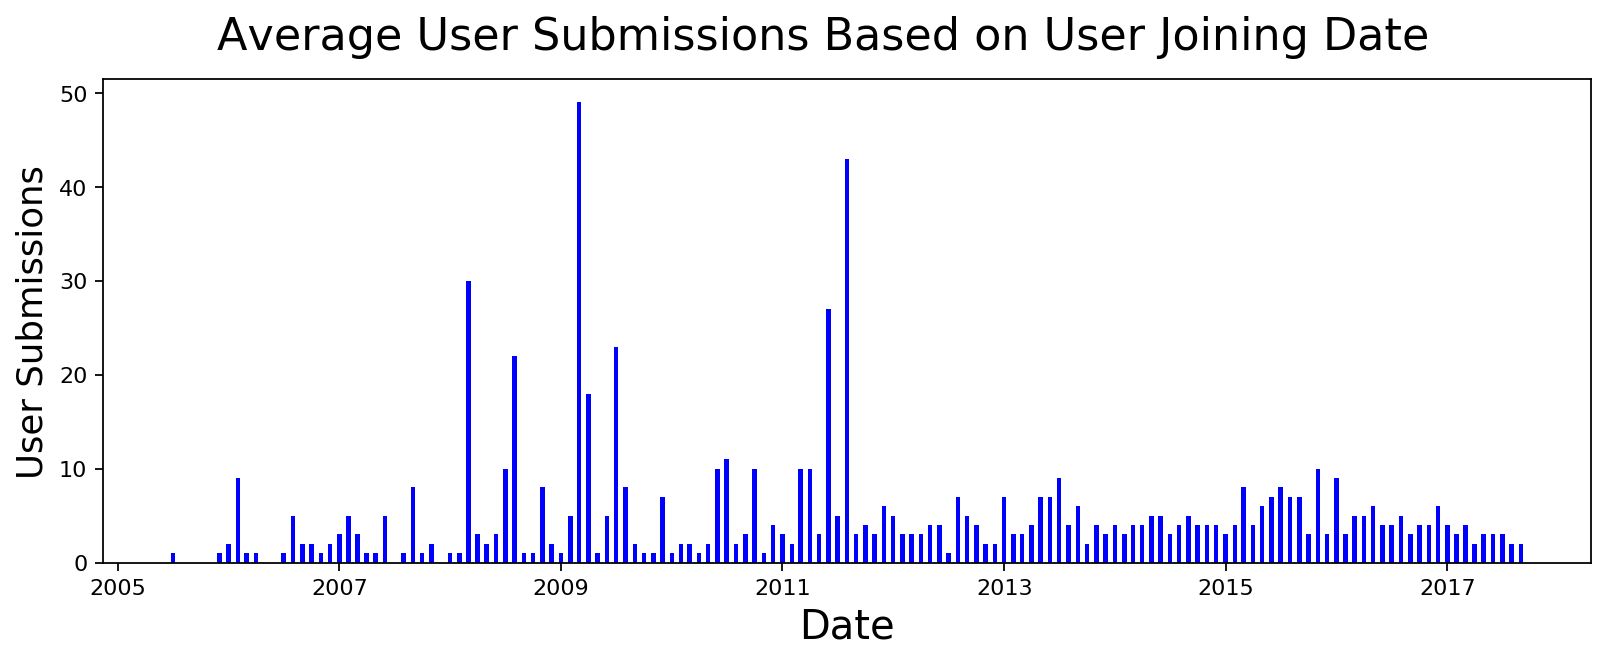

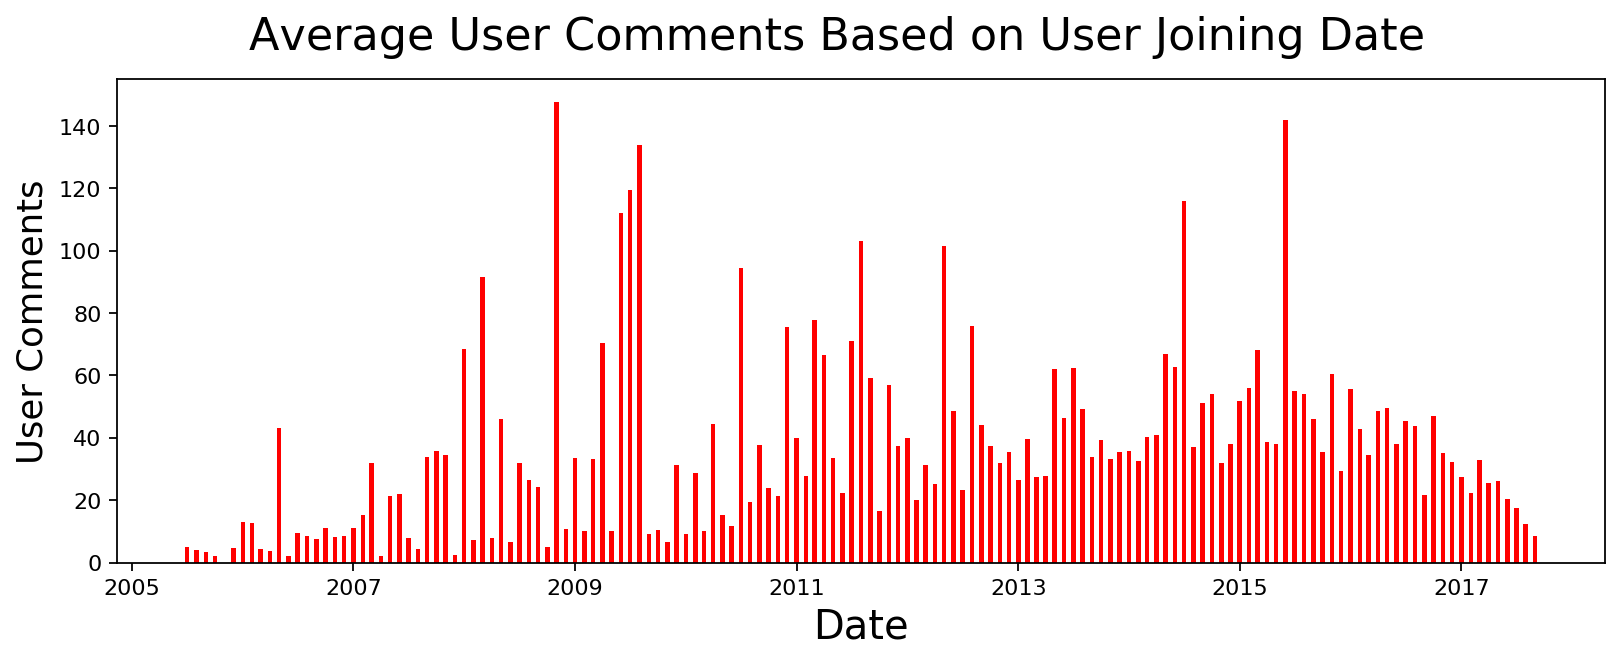

In [111]:
# Number of submissions by authors age
user_submissions = cursor.execute("select date(user_since, 'start of month') as month, avg(count) from users join (select posted_by, count(*) as count from submissions group by posted_by) on users.user_id==posted_by group by month").fetchall()
user_comments = cursor.execute("select date(user_since, 'start of month') as month, avg(count) from users join (select posted_by, count(*) as count from comments group by posted_by) on users.user_id==posted_by group by month").fetchall()

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in user_submissions], [int(y) for x,y in user_submissions], 'Date', 'User Submissions',
          'Average User Submissions Based on User Joining Date', color='blue', width=15)

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in user_comments], [y for x,y in user_comments], 'Date', 'User Comments',
          'Average User Comments Based on User Joining Date', color='red', width=15)


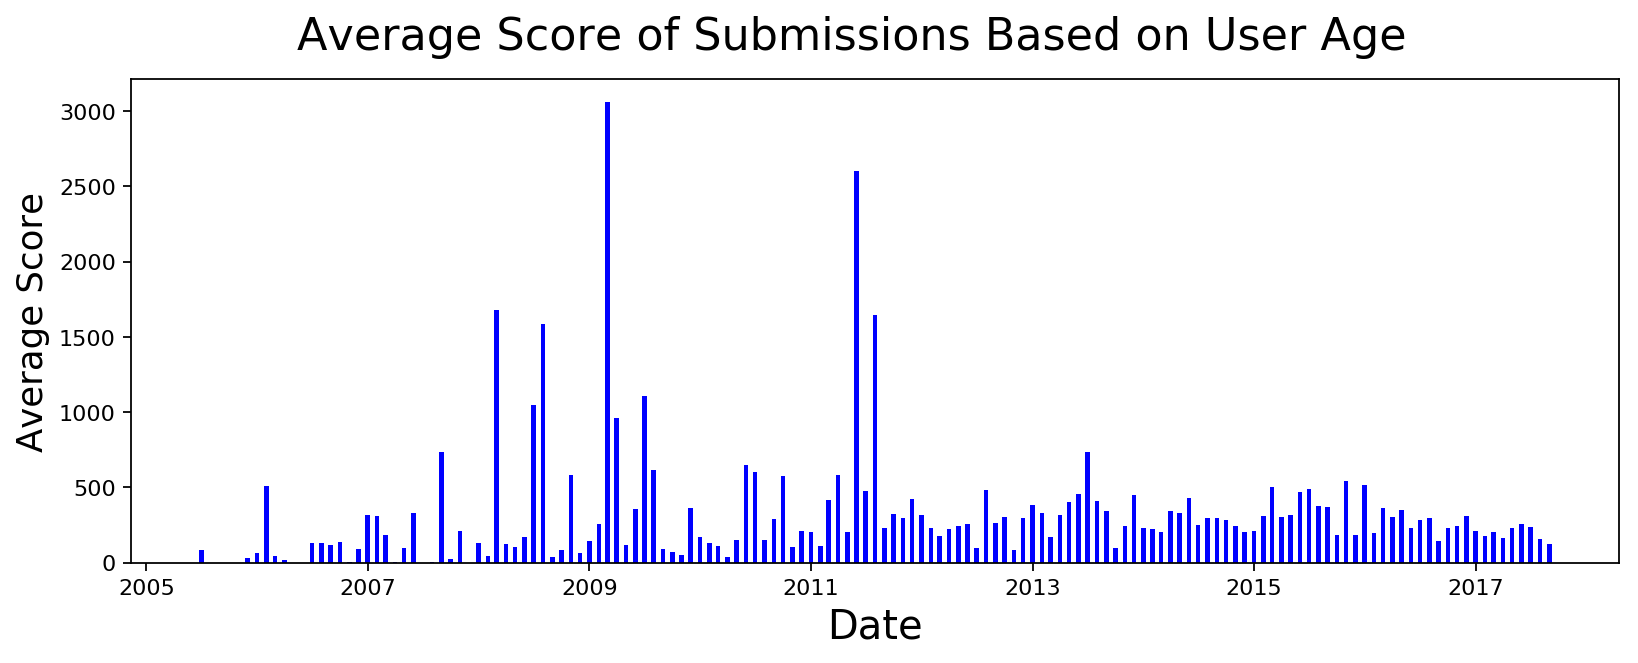

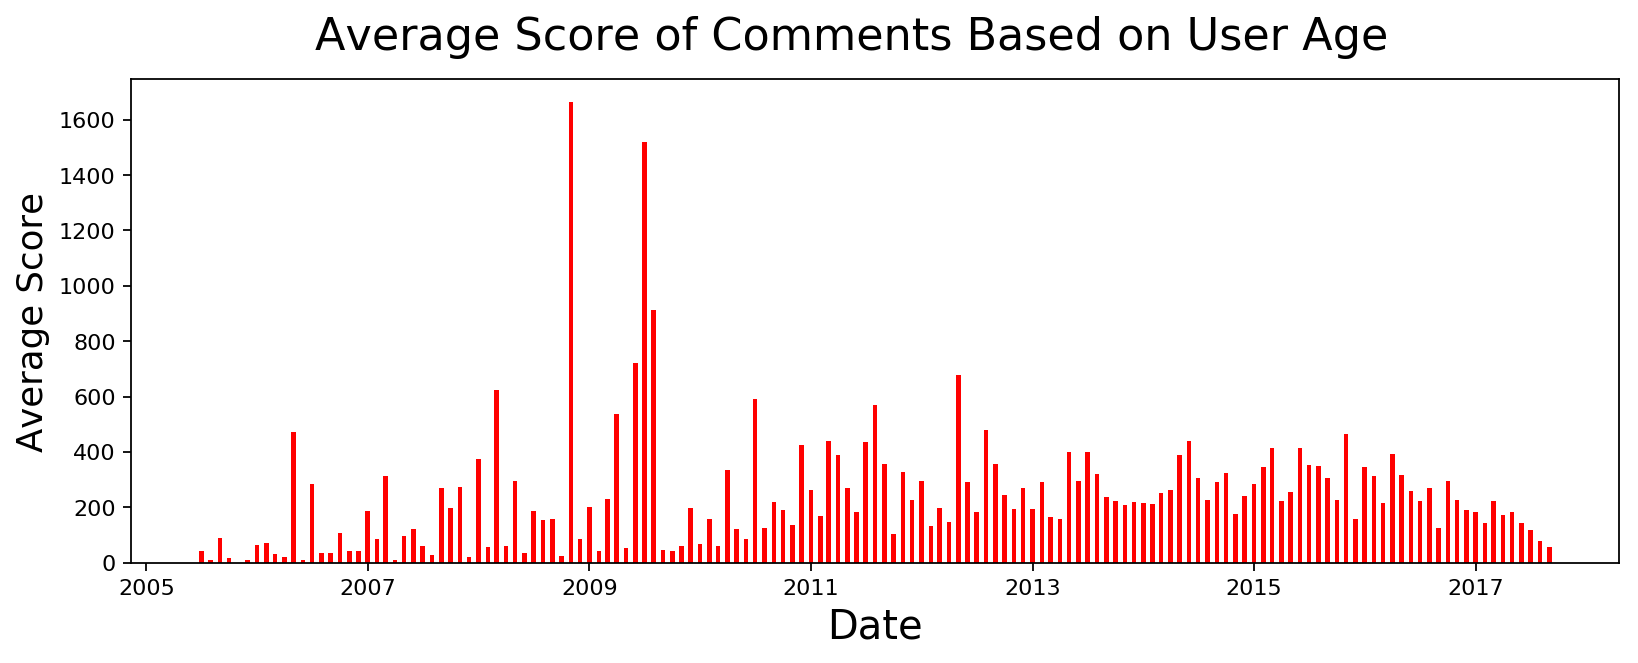

In [112]:
# Score of submissions by authors age
user_submission_scores = cursor.execute("select date(user_since, 'start of month') as month, avg(score) from users join (select posted_by, sum(score) as score from submissions group by posted_by) on users.user_id==posted_by group by month").fetchall()
user_comment_scores = cursor.execute("select date(user_since, 'start of month') as month, avg(score) from users join (select posted_by, sum(score) as score from comments group by posted_by) on users.user_id==posted_by group by month").fetchall()

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in user_submission_scores], [y for x,y in user_submission_scores], 'Date', 'Average Score',
          'Average Score of Submissions Based on User Age', color='blue', width=15)

plot_data([datetime.strptime(x, '%Y-%m-%d') for x,y in user_comment_scores], [y for x,y in user_comment_scores], 'Date', 'Average Score',
          'Average Score of Comments Based on User Age', color='red', width=15)

## Most Active Users

These are the users who made either most submissions or most comments. Anyone who worries about AI taking away jobs has one more data point here. Instead of recruiting hundreds of people, we have bots doing quite a lot of grunt work. I am pretty sure all those humans currently recruited to post large number of messages against other political parties and companies will be next. You know who you are.

In [66]:
# Most frequent submission authors
data = cursor.execute("select posted_by, count(*) as count from submissions group by posted_by order by count desc").fetchmany(11)[1:]
display(HTML(tabulate.tabulate(data, headers=['Username', 'Submissions'], tablefmt='html')))

Username,Submissions
gcs8,643
pannagasamir,610
swacchreddit,556
aryaninvader,481
modiusoperandi,458
TemptNotTheBlade,454
hipporama,439
HornOK,323
ppatra,322
darklordind,316


In [67]:
# Most frequent comment authors
data = cursor.execute("select posted_by, count(*) as count from comments group by posted_by order by count desc").fetchmany(11)[1:]
display(HTML(tabulate.tabulate(data, headers=['Username', 'Comments'], tablefmt='html')))

Username,Comments
samacharbot2,33221
AwkwardMod,26021
TemptNotTheBlade,11680
anti_anti_adblock,9350
gcs8,6639
bhiliyam,6562
donoteatthatfrog,5686
swacchreddit,5569
ppatra,5558
charavaka,5297


## Most Popular Users

These are the users who received maximum score for their submissions and comments. Looks like these highly active users need investigation.

In [68]:
# Most popular (based on score) submission authors
data = cursor.execute("select posted_by, sum(score) as score from submissions group by posted_by order by score desc").fetchmany(11)[1:]
display(HTML(tabulate.tabulate(data, headers=['Username', 'Submission Score'], tablefmt='html')))

Username,Score
hipporama,43363
pannagasamir,34396
wordswithmagic,28209
aryaninvader,26022
TemptNotTheBlade,22450
gcs8,22383
ironypatrol,21829
modiusoperandi,21447
spikyraccoon,19153
ab0mI,17806


In [69]:
# Most popular (based on score) comment authors
data = cursor.execute("select posted_by, sum(score) as score from comments group by posted_by order by score desc").fetchmany(11)[1:]
display(HTML(tabulate.tabulate(data, headers=['Username', 'Comment Score'], tablefmt='html')))

Username,Comment Score
TemptNotTheBlade,61177
Not_a_kulcha,59741
ribiy,46236
samacharbot2,39752
swacchreddit,37643
AwkwardMod,37398
modiusoperandi,35069
charavaka,33366
bhiliyam,32679
GoldPisseR,32073


## Submissions by Flair

I think Politics takes up quite a lot of space in Indian mind and it shows in the data. ~24% of posts were tagged with Politics flair. I am actually surprised that we had more Non-Politics posts than Politics.

With respect to submission score, taking direct average is useless because of many custom flairs. If I filter out all the flairs with less than 10 posts, we have a much more representative sample. From that, excluding subreddit management related flairs, Politics ranks sixth highest rated flair with AMA, Sports, Reddiquette, Non-political and Entertainment taking top spots. That sounds reasonable. **If submission scores were to be considered as a proxy for user interests, people are more interested in other things than Politics but somehow more Political posts are made than people are interested in.** I wonder how that happens.

In [130]:
# Post count by flair
data = cursor.execute("select link_flair_text, (count*100.0/(select count(*) from submissions)) as percent from (select link_flair_text, count(*) as count from submissions group by link_flair_text)  order by percent desc").fetchmany(15)
display(HTML(tabulate.tabulate(data, headers=['Flair', 'Submission Percentage'], tablefmt='html')))

Flair,Submission Percentage
Non-Political,28.5036
Politics,23.8635
AskIndia,13.3852
Policy/Economy,6.13779
Demonetization,3.90912
Business/Finance,3.07831
[R]eddiquette,2.77312
Science/Technology,2.6469
Entertainment,2.39822
Policy & Economy,1.91406


In [140]:
# Post score by flair
data = cursor.execute("select link_flair_text, score from (select link_flair_text, avg(score) as score, count(*) as count from submissions group by link_flair_text) where count > 10 order by score desc").fetchmany(15)
display(HTML(tabulate.tabulate(data, headers=['Flair', 'Submission Score'], tablefmt='html')))

Flair,Submission Score
Misleading,167.048
Moderated,161.8
AMA,124.183
Unverified,112.259
Sports,91.9378
Casual AMA,80.9167
TIL Rule Violation.,76.617
[R]eddiquette,73.7887
Non-Political,66.3399
Entertainment,61.1406


## Word Cloud of Submissions

What data analysis is complete without great looking wordclouds? So here they are. I think the sizes of words should surprise no one. I was expecting a lot bigger "Modi" but I guess other non-important words took up too much of space.

(-0.5, 1199.5, 599.5, -0.5)

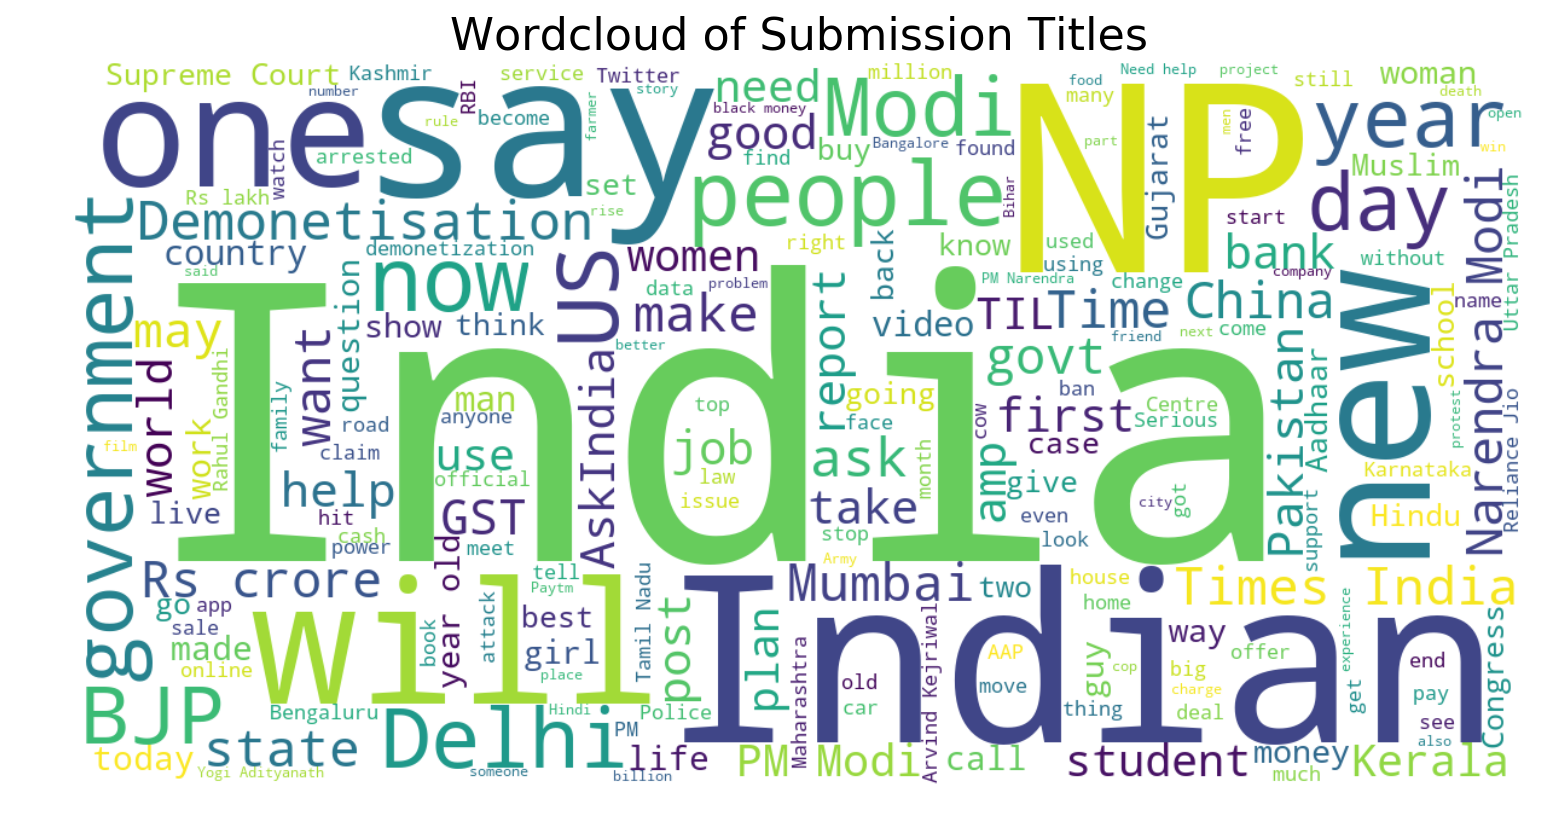

In [121]:
import base64
import operator
from wordcloud import WordCloud
# Submission title word cloud
submission_title = ''
for b64text in cursor.execute("select title from submissions").fetchall():
    text = base64.b64decode(b64text[0])
    submission_title += text + ' '
title_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(submission_title)
fig = plt.figure(figsize=(12,6), dpi=80)
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.title('Wordcloud of Submission Titles', fontsize=20)
plt.axis("off")

(-0.5, 1199.5, 599.5, -0.5)

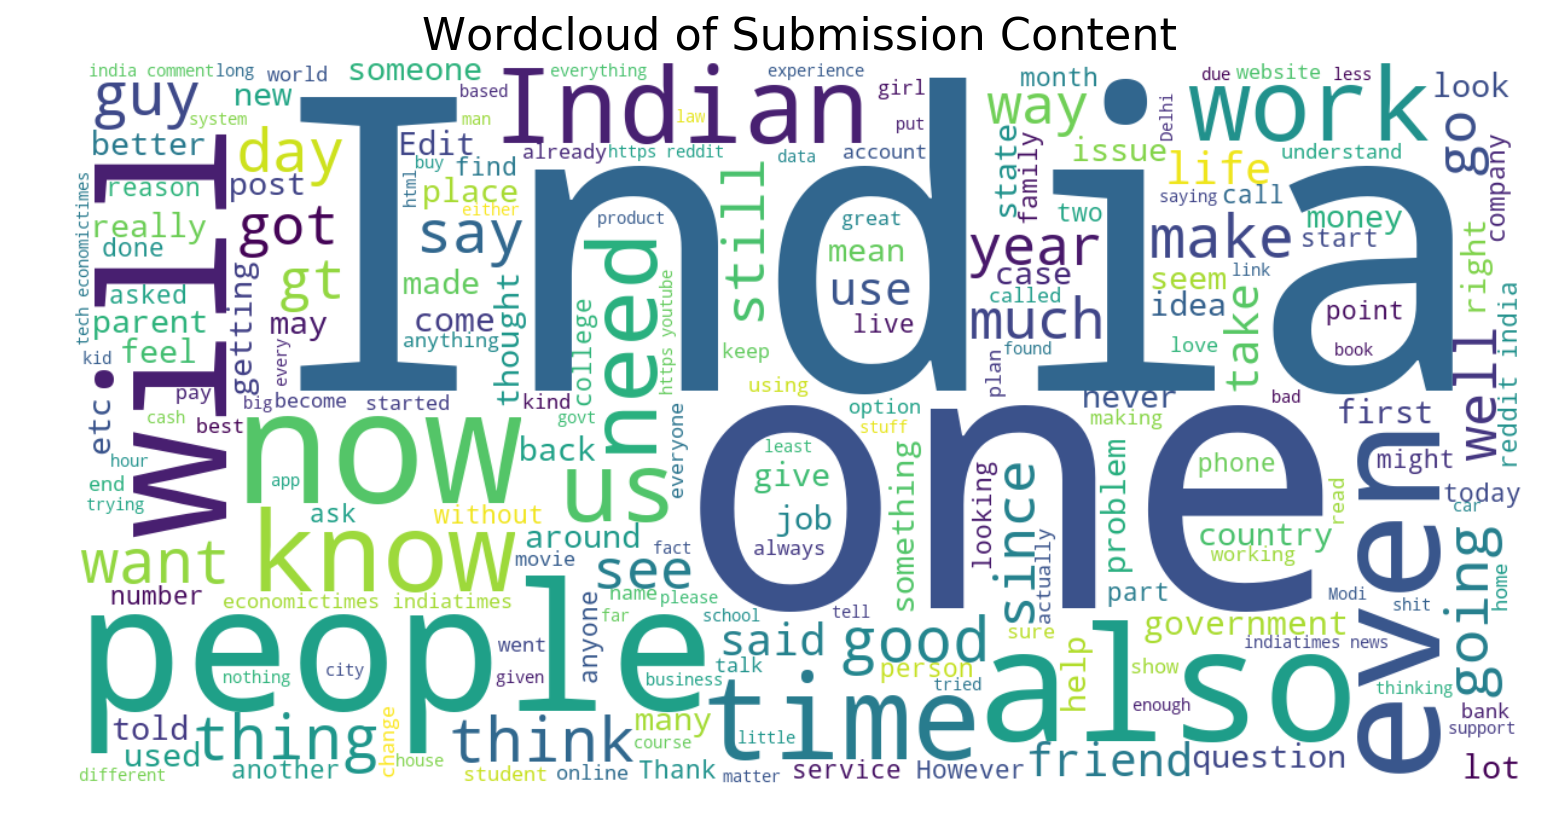

In [120]:
# Submission text word cloud
submission_text = ''
for b64text in cursor.execute("select content from submissions").fetchall():
    text = base64.b64decode(b64text[0])
    submission_text += text + ' '
text_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(submission_text)
fig = plt.figure(figsize=(12,6), dpi=80)
plt.imshow(text_wordcloud, interpolation='bilinear')
plt.title('Wordcloud of Submission Content', fontsize=20)
plt.axis("off")

(-0.5, 1199.5, 599.5, -0.5)

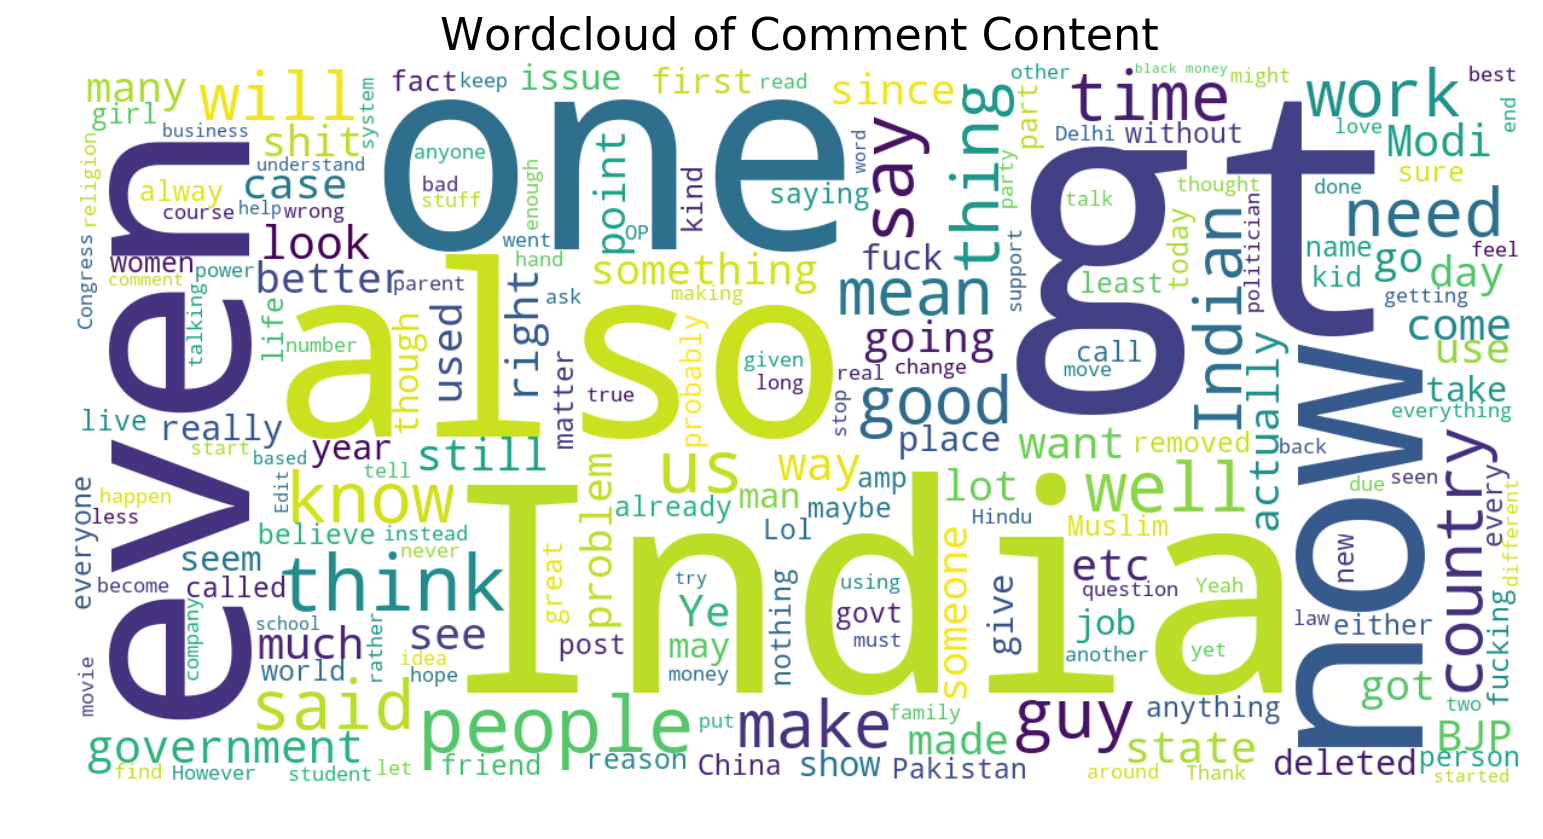

In [143]:
# Comments text word cloud
comment_text = ''
for b64text in cursor.execute("select content from comments where score > 5").fetchall():
    text = base64.b64decode(b64text[0])
    comment_text += text + ' '
comment_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(comment_text)
fig = plt.figure(figsize=(12,6), dpi=80)
plt.imshow(comment_wordcloud, interpolation='bilinear')
plt.title('Wordcloud of Comment Content', fontsize=20)
plt.axis("off")

## Code and Extras

Code for loading data into database is below.

```python
    import avro
    import base64
    import io
    import os
    import praw
    import sqlite3
    import sys

    from avro.datafile import DataFileReader
    from avro.io import DatumReader
    from datetime import datetime
    from multiprocessing.dummy import Pool as ThreadPool

    epoch = datetime(1970,1,1)

    def safe_int(val):
        if val != None:
            return val
        else:
            return 0

    class RedditDataLoader(object):
        def __init__(self):
            self.conn = sqlite3.connect('reddit.db')

        def get_author_info(self, reddit, author_name):
            try:
                author = reddit.redditor(author_name)
                user_since = datetime.utcfromtimestamp(author.created_utc)
                return author_name, "'%s', '%s', %f, %f" % (author_name, user_since, author.link_karma, author.comment_karma)
            except Exception, e:
                print 'Failed with exception', e
                return author_name, None

        def fetch_author_info(self):
            reddit = praw.Reddit(client_id='YOUR_REDDIT_CLIENT_ID', client_secret='SECRET', 
                    username='USERNAME', password='PASSWORD', user_agent='script')
            cursor = self.conn.cursor()
            submission_authors = [item[0] for item in cursor.execute('select distinct(posted_by) from submissions').fetchall()]
            comment_authors = [item[0] for item in cursor.execute('select distinct(posted_by) from comments').fetchall()]
            all_authors = sorted(list(set(submission_authors + comment_authors)))
            print 'Found %d authors' % len(all_authors)
            pool = ThreadPool(12)
            all_authors_data = pool.map(lambda author: self.get_author_info(reddit, author), all_authors)
            pool.close()
            pool.join()
            print 'Done fetching data'
            for author_name, author_details in all_authors_data:
                if author_details==None: continue
                self._add_author_details(cursor, author_name, author_details)

        def read_data(self, submission_file_name, comment_file_name):
            cursor = self.conn.cursor()
            # read and load submissions
            print 'Reading and loading submissions data'
            submission_file = DataFileReader(open(submission_file_name, 'rb'), DatumReader())
            for submission in submission_file:
                self._add_submission_details(cursor, submission)

            # read and load submissions
            print 'Reading and loading comments data'
            comment_file = DataFileReader(open(comment_file_name, 'rb'), DatumReader())
            for comment in comment_file:
                self._add_comment_details(cursor, comment)

        def create_tables(self):
            c = self.conn.cursor()
            # If some tables exist, we don't need to create new ones
            c.execute("SELECT count(*) FROM sqlite_master where type='table'")
            if c.fetchone()[0] > 0:
                return
            c.execute('''CREATE TABLE users 
                            (user_id text PRIMARY KEY, user_since timestamp, 
                            link_karma real, comment_karma real)''')
            c.execute('''CREATE TABLE submissions
                            (submission_id text PRIMARY KEY, title text, content text,
                            link_flair_text text, posted_at timestamp, posted_by text, 
                            upvotes int, downvotes int, score int, num_comments int)''')
            c.execute('''CREATE TABLE comments
                            (comment_id text PRIMARY KEY, submission_id text, parent_comment_id text,
                            content text, posted_at timestamp, posted_by text,
                            upvotes int, downvotes int, score int)''')
            self.conn.commit()

        def _add_submission_details(self, cursor, submission):
            try:
                created_at = datetime.utcfromtimestamp(int(submission['created_utc']))
                cursor.execute("SELECT * FROM submissions WHERE submission_id='%s'" % submission['id'])
                if cursor.fetchone() != None:
                    return
                values = "'%s', '%s', '%s', '%s', '%s', '%s', %d, %d, %d, %d" % (
                            submission['id'], base64.b64encode(submission['title'].encode('utf-8')), 
                            base64.b64encode(submission['selftext'].encode('utf-8')), submission['link_flair_text'],
                            created_at, submission['author'], safe_int(submission['ups']), safe_int(submission['downs']), 
                            safe_int(submission['score']), safe_int(submission['num_comments']))
                cursor.execute("INSERT INTO submissions VALUES (%s)" % values)
                self.conn.commit()
            except ValueError,e:
                pass
            except Exception, e:
                print submission, e

        def _add_comment_details(self, cursor, comment):
            created_at = datetime.utcfromtimestamp(int(comment['created_utc']))
            cursor.execute("SELECT * FROM comments WHERE comment_id='%s'" % comment['id'])
            if cursor.fetchone() != None:
                return
            values = "'%s', '', '%s', '%s', '%s', '%s', %d, %d, %d" % (
                        comment['id'], comment['parent_id'],
                        base64.b64encode(comment['body'].encode('utf-8')), 
                        created_at, comment['author'], safe_int(comment['ups']), safe_int(comment['downs']), safe_int(comment['score']))
            cursor.execute("INSERT INTO comments VALUES (%s)" % values)
            self.conn.commit()

        def _add_author_details(self, cursor, author_name, author_details):
            try:
                cursor.execute("SELECT * FROM users WHERE user_id='%s'" % author_name)
                if cursor.fetchone() != None:
                    return
                cursor.execute('INSERT INTO users VALUES (%s)' % author_details)
                self.conn.commit()
            except Exception, e:
                print e

    if __name__=='__main__':
        data_loader = RedditDataLoader()
        data_loader.create_tables()
        data_loader.read_data('data/submissions.avro', 'data/comments.avro')
        data_loader.fetch_author_info()
        print 'Done loading'
```

Feel free to contact me if you have any questions!